In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import os
from os import path
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !unzip '/content/gdrive/MyDrive/Soft Computing/Assignment 2/Dataset A.zip'

In [ ]:
dataset_csv = pd.read_csv('/content/training-a.csv')
dataset_csv = dataset_csv[['filename', 'digit']]


In [ ]:
dataset_csv.head()

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [ ]:
class DigitDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

TRAIN_PATH = '/content/training-a'
dataset  = DigitDataset(dataset_csv, TRAIN_PATH, train_transform)

print("Trainig Samples: ",len(dataset))

Trainig Samples:  19702


In [ ]:
dataset[0][0].size()

torch.Size([1, 28, 28])

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset,[15000,4702])

# Experiment 1

In [ ]:
# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10

learning_rate = 0.01


num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

iteration_loss = []
accuracy_l = []

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### 4th hidden layer: 100 --> 100
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_4 = nn.ReLU()

        ### 5th hidden layer: 100 --> 100
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_5 = nn.ReLU()

        ### 6th hidden layer: 100 --> 100
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 4th hidden layer
        self.relu_6 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        # x = x.view(x.shape[0], -1)
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.relu_4(out)

        ### 5th hidden layer
        out  = self.linear_5(out)
        ### Non-linearity in 5th hidden layer
        out = self.relu_5(out)

        ### 6th hidden layer
        out  = self.linear_6(out)
        ### Non-linearity in 6th hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)


# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        if iter % 100 == 0:
            print("\r>> Current Iteration {}".format(iter+1),end='')

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            accuracy_l.append(accuracy)

            # Print Loss
            print('\nIteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

>> Current Iteration 501
Iteration: 500. Loss: 2.2988693714141846. Accuracy: 10.14461931093152
>> Current Iteration 1001
Iteration: 1000. Loss: 2.303428888320923. Accuracy: 9.846873670778391
>> Current Iteration 1501
Iteration: 1500. Loss: 2.293372869491577. Accuracy: 10.017014036580179
>> Current Iteration 2001
Iteration: 2000. Loss: 2.3089041709899902. Accuracy: 9.931943853679286
>> Current Iteration 2501
Iteration: 2500. Loss: 2.300217628479004. Accuracy: 9.549128030625265
>> Current Iteration 3001
Iteration: 3000. Loss: 2.2989563941955566. Accuracy: 9.50659293917482
>> Current Iteration 3501
Iteration: 3500. Loss: 2.308377742767334. Accuracy: 9.655465759251383
>> Current Iteration 4001
Iteration: 4000. Loss: 2.30167818069458. Accuracy: 9.50659293917482
>> Current Iteration 4501
Iteration: 4500. Loss: 2.2994565963745117. Accuracy: 9.846873670778391
>> Current Iteration 5001
Iteration: 5000. Loss: 2.296848773956299. Accuracy: 9.655465759251383
>> Current Iteration 5501
Iteration: 550

[2.2988693714141846, 2.303428888320923, 2.293372869491577, 2.3089041709899902, 2.300217628479004, 2.2989563941955566, 2.308377742767334, 2.30167818069458, 2.2994565963745117, 2.296848773956299, 2.294395923614502, 2.30000901222229, 2.304549217224121, 2.300110340118408, 2.304222345352173, 2.306472063064575, 2.3035569190979004, 2.297137498855591, 2.299344539642334, 2.2926642894744873, 2.2956020832061768, 2.290688991546631, 2.2909116744995117, 2.274075984954834, 2.240955114364624, 2.1839797496795654, 2.0737059116363525, 2.18693470954895, 2.0536937713623047, 2.195263385772705, 2.0738718509674072, 2.346072196960449, 1.8956489562988281, 1.9238474369049072, 1.9047324657440186, 2.0595340728759766, 2.2482216358184814, 1.8937877416610718, 2.1651523113250732]


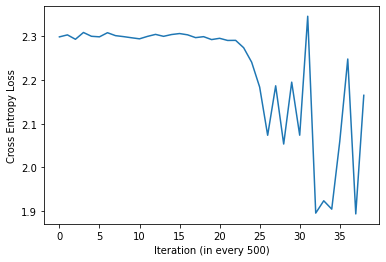

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # weights & biases
    torch.save(model.state_dict(), 'exp_01_1.pkl')

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load('/content/exp_01_1.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


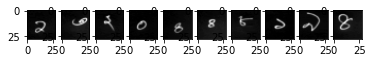

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [ ]:
predictions = model.forward(images[:10].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [8 9 6 8 6 5 1 9 8 6]
